In [1]:
%matplotlib ipympl
import h5py
import numpy as np
import healpy as hp
import fitsio
from matplotlib import pyplot as plt

import sys
sys.path.append("../../xCell/")
from xcell.mappers.mapper_DESY3wl import MapperDESY3wl
from xcell.mappers.mapper_KiDS1000 import MapperKiDS1000
from xcell.mappers.mapper_HSC_DR1wl import MapperHSCDR1wl

import pymaster as nmt
import sacc
import scipy
import yaml

# Produce footprint cut for HSC

In [38]:
masks = {}
# HSC
mask = np.zeros(hp.nside2npix(4096))
for i in range(4):
    mask += hp.read_map(f'/mnt/extraspace/damonge/Datasets/HSC_DR1/lite/mask_mask_HSC_wl{i}_coordC_ns4096.fits.gz')
masks['hsc'] = mask
# K1000
# masks['k1000'] = hp.read_map('/mnt/extraspace/damonge/Datasets/KiDS1000/xcell_reruns/KiDS1000_mask_galaxies_bin0123_ns2048_binary.fits.gz')
# masks['k1000'] = hp.ud_grade(masks['k1000'], 4096)

/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons/lib/python3.9/site-packages/healpy/visufunc.py:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = pylab.figure(fig, figsize=(8.5, 5.4))


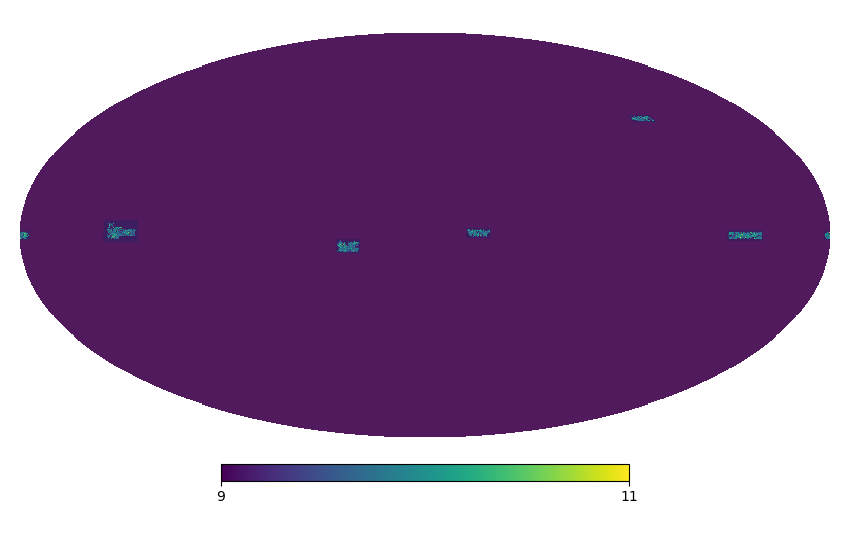

In [44]:
mask = masks['hsc'].copy()
sel = mask>0
mask[sel] = 1
mask[~sel] = hp.UNSEEN
alpha = np.ones_like(mask)
#
pol = hp.query_polygon(hp.npix2nside(mask.size), [hp.ang2vec(*[-111.24, 45.0], lonlat=True),
                       hp.ang2vec(*[-123.7, 45.0], lonlat=True),
                       hp.ang2vec(*[-123.7, 41.77], lonlat=True),
                       hp.ang2vec(*[-111.24, 41.77], lonlat=True)])
mask[pol] = 10

#
pol = hp.query_polygon(hp.npix2nside(mask.size), [hp.ang2vec(*[-134.24, 1.7], lonlat=True),
                       hp.ang2vec(*[-150.15, 1.7], lonlat=True),
                       hp.ang2vec(*[-150.15, -2.07], lonlat=True),
                       hp.ang2vec(*[-134.24, -2.07], lonlat=True)])
mask[pol] = 10

#
pol = hp.query_polygon(hp.npix2nside(mask.size), [hp.ang2vec(*[-18.2, 2.41], lonlat=True),
                       hp.ang2vec(*[-29.5, 2.41], lonlat=True),
                       hp.ang2vec(*[-29.5, -0.92], lonlat=True),
                       hp.ang2vec(*[-18.2, -0.92], lonlat=True)])
mask[pol] = 10

#
pol = hp.query_polygon(hp.npix2nside(mask.size), [hp.ang2vec(*[39.6, -1.55], lonlat=True),
                       hp.ang2vec(*[28.9, -1.55], lonlat=True),
                       hp.ang2vec(*[28.9, -6.7], lonlat=True),
                       hp.ang2vec(*[39.6, -6.7], lonlat=True)])
mask[pol] = 10


#
pol = hp.query_polygon(hp.npix2nside(mask.size), [hp.ang2vec(*[180, 1.3], lonlat=True),
                       hp.ang2vec(*[175.15, 1.3], lonlat=True),
                       hp.ang2vec(*[175.15, -1.94], lonlat=True),
                       hp.ang2vec(*[180, -1.94], lonlat=True)])
mask[pol] = 10

#
pol = hp.query_polygon(hp.npix2nside(mask.size), [hp.ang2vec(*[-180, 1.3], lonlat=True),
                       hp.ang2vec(*[-177.21, 1.3], lonlat=True),
                       hp.ang2vec(*[-177.21, -1.75], lonlat=True),
                       hp.ang2vec(*[-180, -1.75], lonlat=True)])
mask[pol] = 10

# Remove also KiDS part
pol = hp.query_polygon(hp.npix2nside(mask.size), [hp.ang2vec(*[142.63, 5.3], lonlat=True),
                       hp.ang2vec(*[127.7, 5.3], lonlat=True),
                       hp.ang2vec(*[127.7, -2.6], lonlat=True),
                       hp.ang2vec(*[142.63, -2.6], lonlat=True)])
mask[pol] = 10

hp.mollview(mask)

hp.mollview(masks['hsc'], cbar=False, reuse_axes=True, alpha=alpha*0.8, badcolor='lightgray', title='')
# hp.mollview(masks['k1000'], cbar=False, reuse_axes=True, alpha=alpha*0.2, badcolor='lightgray', title='')

print(mask[mask==1].sum())

if mask[mask==1].sum() == 0:
    mask[mask<0] = 0
    mask[mask>0] = 1

    # hp.write_map('/mnt/extraspace/damonge/Datasets/HSC_DR1/lite/HSCDR1wl_mask_galaxies_bin0123_ns4096_binary_nowholes.fits.gz', mask)

# Test cut

In [2]:
# with open("../../xCell/input/DESY3wl__0_noPixWin.yml", "r") as stream:
#     s = yaml.safe_load(stream)
# s

In [3]:
# with open("../../xCell/input/KiDS1000__0.yml", "r") as stream:
#     s = yaml.safe_load(stream)
# s

In [4]:
# with open("../../xCell/input/HSCDR1wl__0.yml", "r") as stream:
#     s = yaml.safe_load(stream)
# s

In [15]:
mappers = {}

# DESY3
config = {"zbin": 0,
          "mode": "shear",
          "indexcat": '/mnt/extraspace/damonge/Datasets/DES_Y3/catalogs/DESY3_indexcat_zbin0.h5',
          'file_nz': '/mnt/extraspace/damonge/Datasets/DES_Y3/data_products/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits',
          # 'path_rerun': 'prueba/DESY3wl',
          'mask_name': 'mask_DESY3wl0_noHSCnoK1000',
          'nside': 4096,
          'coords': 'C', 
          'remove_overlap': {'HSC': '/mnt/extraspace/damonge/Datasets/HSC_DR1/lite/HSCDR1wl_mask_galaxies_bin0123_ns4096_binary_nowholes.fits.gz',
                             'K1000': '/mnt/extraspace/damonge/Datasets/KiDS1000/xcell_reruns/KiDS1000_mask_galaxies_bin0123_ns2048_binary_nowholes.fits.gz'}}
mappers['desy3'] = MapperDESY3wl(config)


# KiDS
config = {'mapper_class': 'MapperKiDS1000',
         'data_catalog': '/mnt/extraspace/damonge/Datasets/KiDS1000/KiDS_DR4.1_ugriZYJHKs_SOM_gold_WL_cat.fits',
         'file_nz': '/mnt/extraspace/damonge/Datasets/KiDS1000/SOM_N_of_Z/K1000_NS_V1.0.0A_ugriZYJHKs_photoz_SG_mask_LF_svn_309c_2Dbins_v2_SOMcols_Fid_blindC_TOMO1_Nz.asc',
         'mode': 'shear',
         'zbin': '0',
         'mask_name': 'mask_KiDS1000__0_noHSC',
         # 'path_rerun': '/mnt/extraspace/damonge/Datasets/KiDS1000/xcell_runs',
                  'nside': 4096,
                  'coords': 'C',
         'remove_overlap': {'HSC': '/mnt/extraspace/damonge/Datasets/HSC_DR1/lite/HSCDR1wl_mask_galaxies_bin0123_ns4096_binary_nowholes.fits.gz'}
         }
mappers['k1000'] = MapperKiDS1000(config)


# HSC
config = {'depth_cut': 24.5,
 'z_edges': [0.3, 0.6],
 'bin_name': 'bin0',
 'data_catalogs': [['/mnt/extraspace/damonge/Datasets/HSC_DR1/HSC_WIDE_GAMA09H.fits'],
  ['/mnt/extraspace/damonge/Datasets/HSC_DR1/HSC_WIDE_GAMA15H.fits'],
  ['/mnt/extraspace/damonge/Datasets/HSC_DR1/HSC_WIDE_HECTOMAP.fits'],
  ['/mnt/extraspace/damonge/Datasets/HSC_DR1/HSC_WIDE_VVDS_part1.fits',
   '/mnt/extraspace/damonge/Datasets/HSC_DR1/HSC_WIDE_VVDS_part2.fits'],
  ['/mnt/extraspace/damonge/Datasets/HSC_DR1/HSC_WIDE_WIDE12H.fits'],
  ['/mnt/extraspace/damonge/Datasets/HSC_DR1/HSC_WIDE_XMM.fits']],
 'fname_cosmos': '/mnt/extraspace/damonge/Datasets/HSC_DR1/Afterburner_reweighted_COSMOS_photoz_FDFC.fits',
 'fnames_cosmos_ph': ['/mnt/extraspace/damonge/Datasets/HSC_DR1/pdf-s17a_wide-9812.cat.fits',
  '/mnt/extraspace/damonge/Datasets/HSC_DR1/pdf-s17a_wide-9813.cat.fits'],
 'nbin_nz': 100,
 'zlim_nz': [0.0, 4.0],
 'mask_name': 'mask_HSC_wl0',
 'mapper_class': 'MapperHSCDR1wl',
 # 'path_rerun': '/mnt/extraspace/damonge/Datasets/HSC_DR1/lite/',
          'nside': 4096,
          'coords': 'C'}


mappers['hsc'] = MapperHSCDR1wl(config)

In [16]:
masks = {}
for i, (k, m) in enumerate(mappers.items()):
    mask = m.get_mask().copy()
    sel = mask > 0
    mask[sel] = 2*i-2
    mask[~sel] = hp.UNSEEN
    masks[k] = mask
alpha = np.ones_like(masks['desy3'])

KiDS1000_bin0_cat.fits
KiDS1000_bin1_cat.fits
KiDS1000_bin2_cat.fits
KiDS1000_bin3_cat.fits
KiDS1000_bin4_cat.fits
Computing bin bin0 mask


/mnt/zfsusers/gravityls_3/mambaforge/envs/baryons/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)


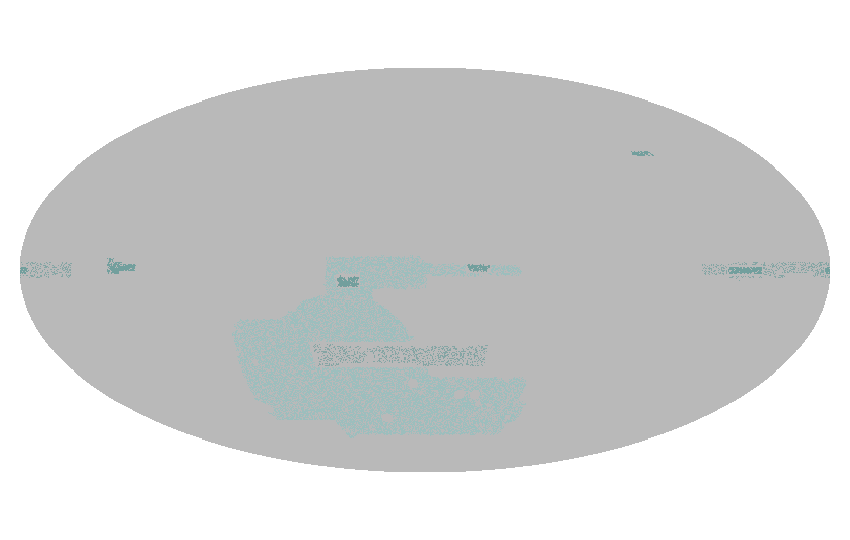

In [17]:
hp.mollview(masks['desy3'], cbar=False)
hp.mollview(masks['k1000'], reuse_axes=True, cbar=False, alpha=alpha * 0.5, badcolor='lightgray',)
hp.mollview(masks['hsc'], reuse_axes=True, cbar=False, alpha=alpha * 0.4, badcolor='lightgray', title='')

In [18]:
masks = {}
for i, (k, m) in enumerate(mappers.items()):
    mask = m.get_mask().copy()
    masks[k] = mask
np.sum(masks['desy3'] * masks['k1000'] * masks['hsc'])

0.0

# Check $C_\ell$

1.1801484862505995


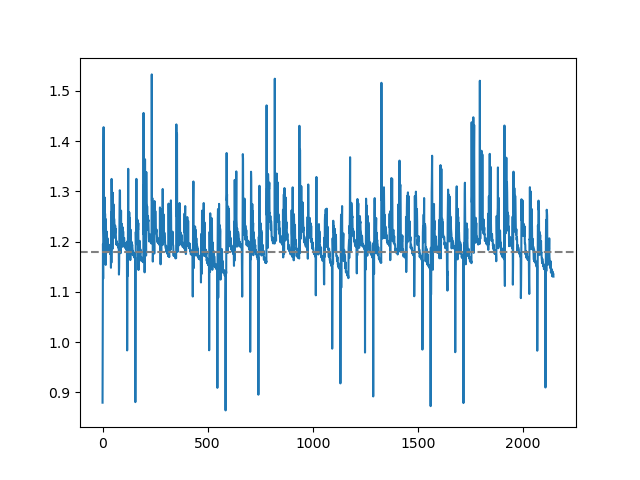

In [26]:
# sdes = sacc.Sacc.load_fits('/mnt/extraspace/davidjamiecarlos/xCell_run1_shear_baryons/DESY3wl_noK1000_noHSCDR1wl_2x2pt_4096/cls_cov_GNG.fits')
# sdes1 = sacc.Sacc.load_fits('/mnt/extraspace/davidjamiecarlos/xCell_run1_shear_baryons/DESY3wl_noK1000_2x2pt_4096/cls_cov_GNG.fits')

sk1000 = sacc.Sacc.load_fits('/mnt/extraspace/davidjamiecarlos/xCell_run1_shear_baryons/KiDS1000_noHSCDR1wl__2x2pt_4096/cls_cov.fits')
# sk10001 = sacc.Sacc.load_fits('/mnt/extraspace/davidjamiecarlos/xCell_run1_shear_baryons/KiDS1000__2x2pt_4096/cls_cov_GNG.fits')

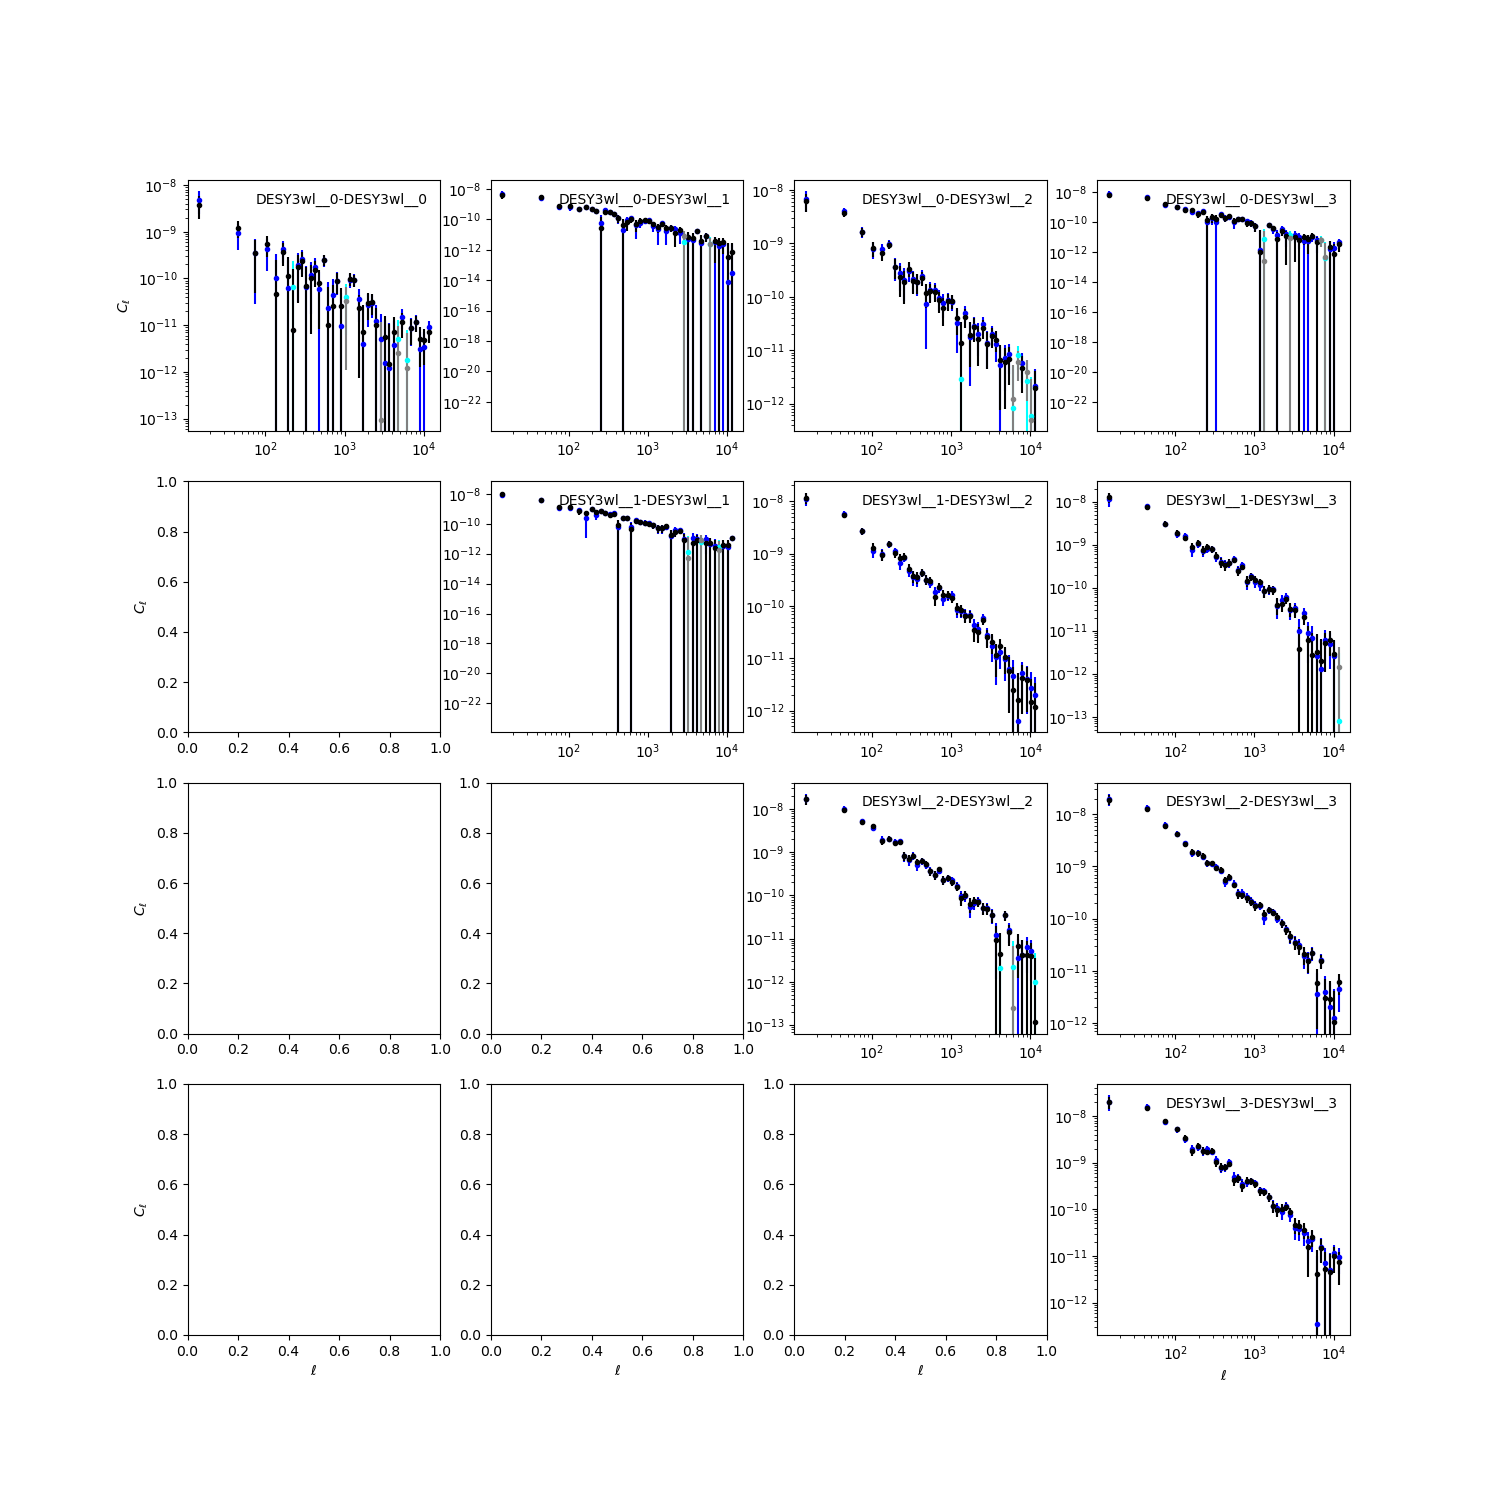

In [20]:
s = sdes.copy()

f, ax = plt.subplots(4, 4, figsize=(15, 15))

for tr1, tr2 in s.get_tracer_combinations():
    i = int(tr1[-1])
    j = int(tr2[-1])
    ell, cl, cov = s.get_ell_cl('cl_ee', tr1, tr2, return_cov=True)
    err = np.sqrt(np.diag(cov))
    sel = cl > 0
    ax[i, j].errorbar(ell[sel], cl[sel], yerr=err[sel], c='blue', fmt='.')
    ax[i, j].errorbar(ell[~sel], -cl[~sel], yerr=err[~sel], c='cyan', fmt='.')


    ell, cl, cov = sdes1.get_ell_cl('cl_ee', tr1, tr2, return_cov=True)
    err = np.sqrt(np.diag(cov))
    sel = cl > 0
    ax[i, j].errorbar(ell[sel], cl[sel], yerr=err[sel], c='k', fmt='.')
    ax[i, j].errorbar(ell[~sel], -cl[~sel], yerr=err[~sel], c='gray', fmt='.')
   
    
    ax[i, j].text(0.95, 0.95, f"{tr1}-{tr2}",
                  horizontalalignment='right', verticalalignment='top',
                  transform=ax[i, j].transAxes)
    ax[i, j].axhline(0, ls='--', color='gray')
    ax[i, j].loglog()
    
for i in range(ax.shape[1]):
    ax[-1, i].set_xlabel('$\ell$')
for i in range(ax.shape[0]):
    ax[i, 0].set_ylabel('$C_\ell$')
plt.show()
# plt.close()

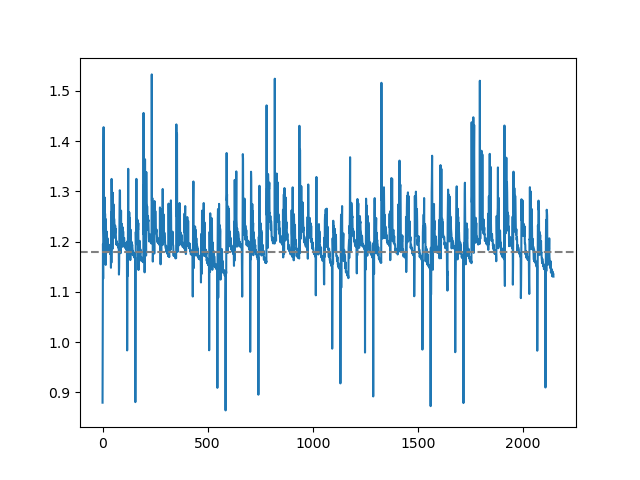

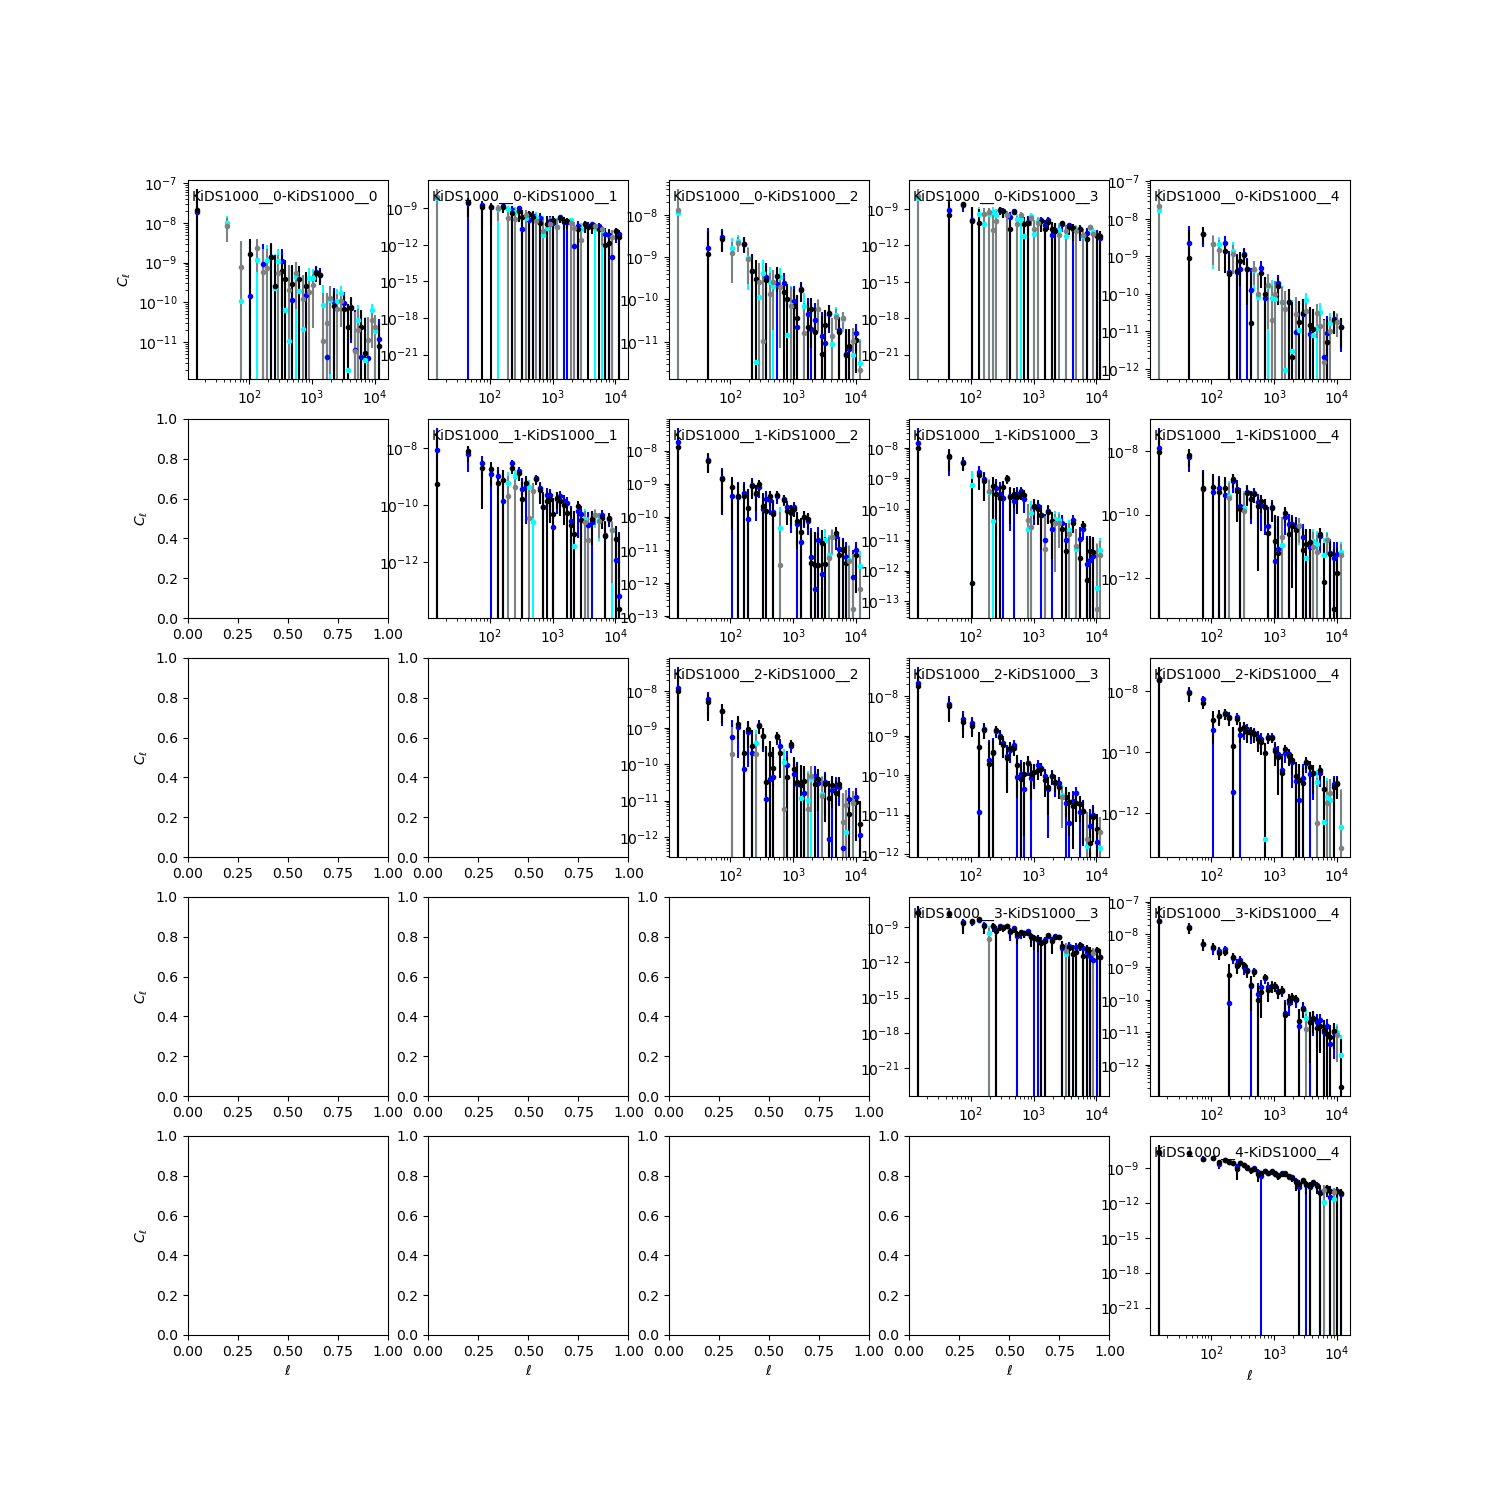

In [41]:
# sk1000 = sacc.Sacc.load_fits('/mnt/extraspace/davidjamiecarlos/xCell_run1_shear_baryons/cls_DESY3_noK1000_noHSCDR1wl_plus_KiDS1000_noHSCDR1wl_cov_4096_GNG.fits')
s = sk1000.copy()

# m = hp.read_map('/mnt/extraspace/damonge/Datasets/KiDS1000/xcell_runs/mask_mask_KiDS1000__0_noHSCDR1wl_coordC_ns4096.fits.gz')
# fsky1 = np.mean(m>0)
# print(fsky1)
# m = hp.read_map('/mnt/extraspace/damonge/Datasets/KiDS1000/xcell_runs/mask_mask_KiDS1000__0_coordC_ns4096.fits.gz')
# fsky2 = np.mean(m>0)
# print(fsky2)
# print(fsky2/fsky1)

f, ax = plt.subplots(1, 1)
plt.plot(np.diag(sk1000.covariance.covmat) / np.diag(sk10001.covariance.covmat))
plt.axhline(fsky2/fsky1, ls='--', color='gray')
plt.show()


f, ax = plt.subplots(5, 5, figsize=(15, 15))

for tr1, tr2 in sk10001.get_tracer_combinations():
    i = int(tr1[-1])
    j = int(tr2[-1])
    ell, cl, cov = s.get_ell_cl('cl_ee', tr1, tr2, return_cov=True)
    err = np.sqrt(np.diag(cov))
    sel = cl > 0
    ax[i, j].errorbar(ell[sel], cl[sel], yerr=err[sel], c='blue', fmt='.')
    ax[i, j].errorbar(ell[~sel], -cl[~sel], yerr=err[~sel], c='cyan', fmt='.')

    
    
    ell, cl, cov = sk10001.get_ell_cl('cl_ee', tr1, tr2, return_cov=True)
    err = np.sqrt(np.diag(cov))
    sel = cl > 0
    ax[i, j].errorbar(ell[sel], cl[sel], yerr=err[sel], c='k', fmt='.')
    ax[i, j].errorbar(ell[~sel], -cl[~sel], yerr=err[~sel], c='gray', fmt='.')
    
    ax[i, j].text(0.95, 0.95, f"{tr1}-{tr2}",
                  horizontalalignment='right', verticalalignment='top',
                  transform=ax[i, j].transAxes)
    ax[i, j].axhline(0, ls='--', color='gray')
    ax[i, j].loglog()
    
for i in range(ax.shape[1]):
    ax[-1, i].set_xlabel('$\ell$')
for i in range(ax.shape[0]):
    ax[i, 0].set_ylabel('$C_\ell$')
plt.show()
# plt.close()